# Event finder 

This notebook will find "events" in the simplest definition i.e. a loser cell apoptosis or a winner cell 

To-do: 
- [x] Input HDF5 file which includes necessary information of x, y, t, fate
- [x] Identify a loser apoptosis x, y, t by invoking tracks[1] for Scr cells and sorting via fate by using tracks[1].fate
- [x] Define the exact time point of a loser cell apoptosis, how many frames it is classed as an apoptosis before the actual event (mainly ensuring false apoptoses aren’t included) 
- [ ] Screen all other tracks in the vicinity of previously obtained x, y, t by using if statement
- [ ] Screen further by excluding all tracks[0].fate =! division
- [ ] Repeat if statement for differing spatiotemporal ‘local environments’, increasing x, y, t  to count instances of mitosis across the whole monolayer over the whole experiment. 
- [ ] Assess viability of capturing a whole experiment in a single heat map, reduce scope if this is unviable. 

Refreshed to-do/different approach: 
- [x] find competitive event using list comprehension
- [x] remember how to find cells not using index but cell ID
- [x] write a function that parses that track(?) and finds local cells nearby


### Load data

In [2]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np

version no.: 0.3.13


In [3]:
filename ='/home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5'
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
#scr_tracks = (tracks[1]) 
#wt_tracks = (tracks[0]) #initially, tracks[0] is the tracks for cell type 0 (ie, WT or Scr etc)
print("Track information loaded")

[INFO][2020/11/24 09:06:34 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/11/24 09:06:34 PM] Loading tracks/obj_type_1
[INFO][2020/11/24 09:06:36 PM] Loading objects/obj_type_1 (205743, 5) (192777 filtered: area>=100)
[INFO][2020/11/24 09:06:37 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/11/24 09:06:37 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/11/24 09:06:37 PM] Loading tracks/obj_type_2
[INFO][2020/11/24 09:06:38 PM] Loading objects/obj_type_2 (39202, 5) (33022 filtered: area>=100)
[INFO][2020/11/24 09:06:38 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded


## Find event

#### Display track information

In [4]:
### this list comp shows scr cell IDs that have apoptosed and their length
[print("ID:", scr_track.ID, scr_track.fate.name, "length:", len(scr_track), "final time point:", scr_track.t[-1])  for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

ID: 19 APOPTOSIS length: 369 final time point: 368
ID: 24 APOPTOSIS length: 381 final time point: 380
ID: 28 APOPTOSIS length: 987 final time point: 986
ID: 29 APOPTOSIS length: 83 final time point: 84
ID: 16 APOPTOSIS length: 6 final time point: 5
ID: 17 APOPTOSIS length: 70 final time point: 70
ID: 6 APOPTOSIS length: 398 final time point: 397
ID: 8 APOPTOSIS length: 456 final time point: 455
ID: 10 APOPTOSIS length: 131 final time point: 130
ID: 15 APOPTOSIS length: 155 final time point: 154
ID: 14 APOPTOSIS length: 125 final time point: 124
ID: 39 APOPTOSIS length: 25 final time point: 29
ID: 49 APOPTOSIS length: 235 final time point: 258
ID: 55 APOPTOSIS length: 18 final time point: 47
ID: 62 APOPTOSIS length: 6 final time point: 41
ID: 63 APOPTOSIS length: 7 final time point: 46
ID: 70 APOPTOSIS length: 6 final time point: 54
ID: 74 APOPTOSIS length: 6 final time point: 58
ID: 79 APOPTOSIS length: 31 final time point: 87
ID: 82 APOPTOSIS length: 29 final time point: 89
ID: 88 APO

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Filter tracks to only include scr apoptosis

In [5]:
### scr_apop is all the scr tracks that have apoptosed
scr_apops = [scr_track for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

##### Show the first classification of each track

In [77]:
for scr_track in scr_apops:
    print(scr_track.label[0], "ID is", scr_track.ID, scr_track.t[0])

APOPTOSIS ID is 19 0
APOPTOSIS ID is 24 0
INTERPHASE ID is 28 0
APOPTOSIS ID is 29 0
APOPTOSIS ID is 16 0
APOPTOSIS ID is 17 0
APOPTOSIS ID is 6 0
APOPTOSIS ID is 8 0
APOPTOSIS ID is 10 0
APOPTOSIS ID is 15 0
APOPTOSIS ID is 14 0
APOPTOSIS ID is 39 5
APOPTOSIS ID is 49 24
APOPTOSIS ID is 55 30
APOPTOSIS ID is 62 36
APOPTOSIS ID is 63 40
APOPTOSIS ID is 70 49
APOPTOSIS ID is 74 53
APOPTOSIS ID is 79 56
APOPTOSIS ID is 82 61
APOPTOSIS ID is 88 69
APOPTOSIS ID is 92 72
APOPTOSIS ID is 101 85
APOPTOSIS ID is 104 87
APOPTOSIS ID is 117 130
METAPHASE ID is 144 233
APOPTOSIS ID is 150 280
APOPTOSIS ID is 158 300
APOPTOSIS ID is 162 311
INTERPHASE ID is 167 336
APOPTOSIS ID is 179 363
APOPTOSIS ID is 181 370
APOPTOSIS ID is 217 419
ANAPHASE ID is 226 439
APOPTOSIS ID is 228 445
APOPTOSIS ID is 252 481
APOPTOSIS ID is 260 489
APOPTOSIS ID is 284 542
ANAPHASE ID is 287 546
ANAPHASE ID is 314 593
APOPTOSIS ID is 315 601
ANAPHASE ID is 335 677
APOPTOSIS ID is 353 715
ANAPHASE ID is 366 734
APOPTOS

## Isolating one track of interest

In [21]:
print("Input cell ID of interest")
cell_ID = int(input())
index = [i for i, scr_apop in enumerate(scr_apops) if scr_apop.ID == cell_ID][0]
target_track = scr_apops[index]

Input cell ID of interest
28


['INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHA

Check the state classifications on that target track 

In [22]:
target_track.label

['INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHA

## Find nearby cells 

In [23]:
target_track

,ID,t,x,y,z,parent,root,state,generation,dummy
0,28,0,452.177521,1351.680176,0.0,28,28,0,0,False
1,28,1,452.246307,1350.421143,0.0,28,28,0,0,False
2,28,2,452.636536,1350.649780,0.0,28,28,0,0,False
3,28,3,451.712341,1351.843628,0.0,28,28,0,0,False
4,28,4,452.278534,1353.136108,0.0,28,28,0,0,False
5,28,5,451.375885,1353.029541,0.0,28,28,0,0,False
6,28,6,450.323517,1352.748291,0.0,28,28,0,0,False
7,28,7,446.505859,1351.428101,0.0,28,28,0,0,False
8,28,8,444.002319,1349.539307,0.0,28,28,0,0,False
9,28,9,442.618195,1346.464722,0.0,28,28,0,0,False


### Functions to measure local neighbourhood for cells of interest

In [24]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(frame)
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_index(target_track):
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            #apop_other_index = target_track.label.index("APOPTOSIS") ## this doesnt return the first of three classifications like i need
            break
    return apop_index

#### merge with above for two outputs?
def find_apoptosis_time(target_track):
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    return apop_time

def find_nearby_wt(target_track, radius = 100, delta_t = 0):
    frame = apop_time + delta_t ## check the delta_t option 
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]##not strictly necessary to have this extra conditional bc scr/wt_tracks are different anyway #and wt_track != target_track]
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
    
    return wt_tracks_in_radius

def find_nearby_wt_mitosis(target_track, delta_t, radius = 100):
    frame = apop_time + delta_t ## check the delta_t option 
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]##not strictly necessary to have this extra conditional bc scr/wt_tracks are different anyway #and wt_track != target_track]
    wt_mitosis_fate_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius and wt_track.fate.name == "DIVIDE"] ## change this to divide within time point
    
    return wt_mitosis_fate_in_radius

In [25]:
apop_index = find_apoptosis_index(target_track)
apop_time = find_apoptosis_time(target_track)
nearby_cells = find_nearby_wt(target_track)
nearby_mitosis = find_nearby_wt_mitosis(target_track, 100)

# to do

- [x] thus far i have nearby tracks that END in a mitosis, but i need nearby tracks that have a mitosis within delta_t of apop_time
- [x] put a circle of radius r on the diagram below
- [ ] check against raw data (ongoing work in raw_data_viewer notebook)
- [x] remove duplicates from nearby list
- [ ] start binning data into different delta_t and r
- [ ] plot that as a histogram type thing

In [27]:
def find_nearby_wt_mitosis(target_track, delta_t, radius = 50):
    frame = apop_time + delta_t 
    dividing_states = ('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] in dividing_states]

    return wt_mitosis_in_radius


In [72]:
delta_t = 100
nearby = []
for t in range(-delta_t, delta_t):
    track = find_nearby_wt_mitosis(target_track, t)
    if [t.ID for t in track] in [t.ID for t in nearby]:
        print("duplicate")
    else:
        #print("division event found")
        nearby += track

duplicate
duplicate


/home/nathan/anaconda3/envs/btrack/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


duplicate
duplicate
duplicate


In [65]:
[t.ID for t in nearby]

[1032, 1103, 1144, 1235, 1323, 1334, 1341]

In [68]:
len(nearby)

7

In [67]:
apop_time

701

In [44]:
target_track.x[apop_index], target_track.y[apop_index]

(673.464599609375, 1573.6832275390625)

# checking against raw data

within 100(either side) frames of apoptime 701 at xy 673, 1573 there are 7 UNIQUE division events

In [74]:
[len(t) for t in nearby]

[12, 10, 19, 21, 6, 3, 24]

In [75]:
nearby[-1]

,ID,t,x,y,z,parent,root,state,generation,dummy
0,1341,777,614.518311,1593.359741,0.0,1323,1323,3,1,False
1,1341,778,614.364685,1593.520630,0.0,1323,1323,2,1,False
2,1341,779,614.633423,1593.275635,0.0,1323,1323,2,1,False
3,1341,780,613.596985,1592.773193,0.0,1323,1323,0,1,False
4,1341,781,613.610291,1592.981934,0.0,1323,1323,0,1,False
5,1341,782,613.893494,1592.781006,0.0,1323,1323,0,1,False
6,1341,783,615.289978,1592.515015,0.0,1323,1323,0,1,False
7,1341,784,614.575012,1592.875000,0.0,1323,1323,0,1,False
8,1341,785,613.394226,1593.333374,0.0,1323,1323,2,1,False
9,1341,786,613.972229,1592.063110,0.0,1323,1323,0,1,False


# display tracks

In [34]:
import matplotlib.pyplot as plt

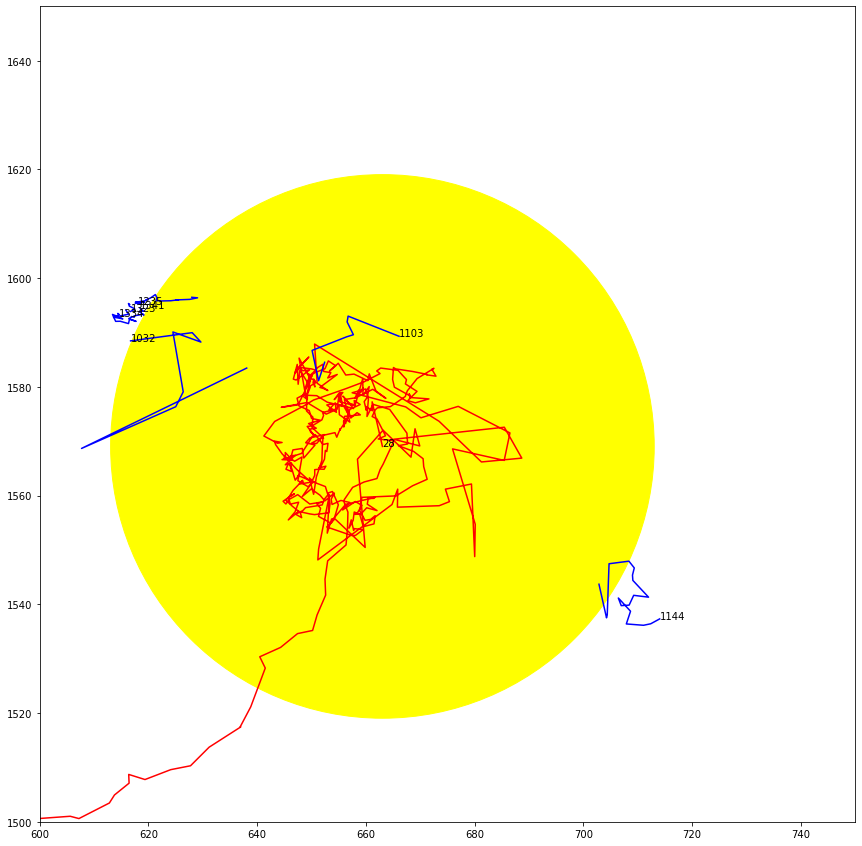

In [76]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((target_track.x[-1], target_track.y[-1]), 50,fill=True, color = 'yellow')
plt.plot(target_track.x, target_track.y, 'r-')
plt.text(target_track.x[-1], target_track.y[-1], target_track.ID)
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
    plt.text(track.x[-1], track.y[-1], track.ID)
axes.set_aspect(1)
axes.add_artist(draw_circle)
plt.xlim(600,750)
plt.ylim(1500,1650)
figure.set_size_inches(15, 15)
plt.show()

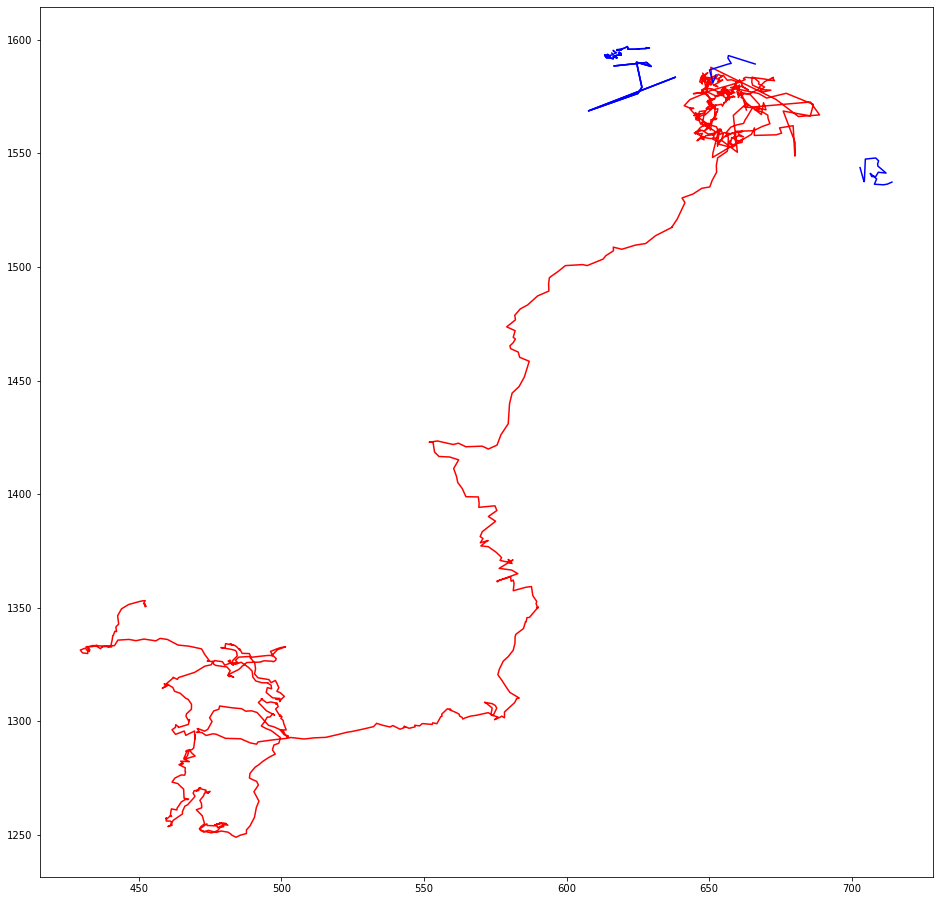

In [41]:
plt.figure(figsize=(16,16))
plt.plot(target_track.x, target_track.y, 'r-')
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
# for mitosis in nearby_mitosis:
#     plt.plot(mitosis.x, mitosis.y, 'g-')


plt.show()

###### misc

In [254]:
#### old nearby list, created issue with list entry
delta_t = 2
old_nearby = []
for t in range(-delta_t, delta_t):
    old_nearby.append(find_nearby_wt_mitosis(target_track, t))
    old_nearby = list(filter(None, old_nearby))
# for i, j in enumerate(nearby): ### BAD HACK needs solving: each entry in the nearby list is entered as a list itself, not a btrack tracklet, so need to redefine as first item in list
#     nearby[i] = nearby[i][0] 

In [ ]:
### ideas i showed guillaume when explaining plan, keeping for future reference

wt_track.label[apop_time] == "DIVIDE"
nearby_mitosis_plust = find_nearby_wt_mitosis(target_track, 200)

In [ ]:
print(target_track.label)
apop_frames = [i for i, j in enumerate(target_track.label) if j == "APOPTOSIS"]
target_track.label[-1]

In [ ]:
wt_tracks[0].label

In [ ]:
wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]

want the below conditional to be ```if wt_track.label[wt_track.t.index(apop_time +- delta_t)] == "APOPTOSIS"```

In [ ]:
### want the conditional to be if wt
wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] == "DIVIDE"]

In [ ]:
##rewriting the list comprehension as a for loop to see if the conditional statement can be achieved

for wt_track in wt_tracks_in_radius:
    if wt_track.fate.name == "DIVIDE":
        
        if wt_track.label[wt_track.t.index(apop_time)] == "DIVIDE":
        ### something to store a mitosis at apop_time
    if wt_track

In [ ]:
wt_track.label[0] ## here we have the state at index 0, and want the state at t = apop_t

## want label at t
track = wt_tracks_in_frame[0]
track_2 = wt_tracks_in_frame[-1]

In [ ]:
### this line pulls the classification from the apoptosis time
track.label[track.t.index(apop_time)]

In [ ]:
### this pulls the index from the time
track.t.index(apop_time)

In [ ]:
target_track.label[target_track.t.index(apop_time)]

In [ ]:
target_track

In [ ]:
apop_time

In [ ]:
wt_tracks_in_frame[0]

In [ ]:
wt_tracks_in_frame[-]